## Introduction ##
Welcome to the sequencing technologies module! In lecture this week, we talked about some of the most common sequencing methods (e.g. Sanger, Illumina) and the steps you may need to take to process or cleanup sequencing data. 

In this module, we'll be exploring a sample FASTQ file and conducting some basic analyses. Our goal is to get the gene count from a file containing sequencing data.

## Setup ##
We'll need [Biopython](https://biopython.org), a set of computational biology and bioinformatics tools for Python. Biopython includes handy tools for sequence alignment, structural biology analyses, and more. If you want Biopython on your local machine and you already have Python installed, try running `pip install biopython`. 

Run the cell below to install Biopython in the notebook.

In [ ]:
try:
    import google.colab
    # install Biopython first
    !pip install biopython
    #import some other handy data analysis tools
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    pass

     |████████████████████████████████| 2.3MB 9.6MB/s 


## Part 1: Sequencing Data - FASTQ Files ##
As mentioned in lecture, FASTQ files are a file format used to store sequences data and PHRED quality scores. We've provided a sample FASTQ file called `s_cere_reads.fastq` (RNA-seq reads from the yeast *S. cerevisiae*). Let's look at the first record, which stores data for one read. As a reminder, this is what the lines in a FASTQ file mean: ![image](file path to image)


In [ ]:
with open('s_cere_reads.fastq', 'r') as f:
  for i in range(4):
    print(f.readline())

@SRR11452750.21.1 21 length=51

CCGAAGCGCCATCTAGATGAATACGTGAGGCCCATTGGAGGCTCCTTGAGA

+SRR11452750.21.1 21 length=51

BBBBBFFFFFFFFFFFFFFFBFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF



Now, we're curious how many records are in this file. 

`SeqIO.parse()` returns an iterator of `SeqRecord` objects. Biopython uses an iterator instead of an array or set when reading files due to potentially large file sizes. FASTQ and FASTA files can go up to the GB range! Luckily, our FASTQ file isn't huge and we can safely store all the objects in an array.

**QUESTION 1**: How many records are in this file? Play with the cell below to find out. 

Your answer here: ___

In [ ]:
from Bio import SeqIO
from Bio import AlignIO
from google.colab import files

records = []
records_iter = SeqIO.parse('s_cere_reads.fastq', "fastq")
for record in records_iter:
  # Don't change this line! We're adding all elements of the 
  # iterator into an array we can work with.
  records.append(record)
#count = #YOUR CODE HERE (*hint* the len() function might be useful!)
#print(count) #UNCOMMENT this line when you have your count variable

Now we have all our records Let's peek at the first element to see what a `SeqRecord` object looks like.

In [ ]:
rec_0 = records[0]
print(rec_0)

ID: SRR11452750.21.1
Name: SRR11452750.21.1
Description: SRR11452750.21.1 21 length=51
Number of features: 0
Per letter annotation for: phred_quality
Seq('CCGAAGCGCCATCTAGATGAATACGTGAGGCCCATTGGAGGCTCCTTGAGA')


## Part 2: Quality Control ##
One of the first steps after obtaining sequencing data is usually quality control. No sequencing method is perfect, and we want to know if we can be confident in our data.

Let's look at the PHRED quality scores of the first record. The PHRED quality scores of a `SeqRecord` object can be accessed with `.letter_annotations["phred_quality"]`.

In [ ]:
phred_scores = rec_0.letter_annotations["phred_quality"]
print(phred_scores)

[33, 33, 33, 33, 33, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 33, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37]


**QUESTION 2a**: What is the average PHRED quality score of all the bases in `rec_0`? Look back at the table provided in lecture, what is the approximate accuracy of this read data?

In [ ]:

mean =  # YOUR CODE HERE
print(mean)

Q2A Answer Here: 

Getting the average of the data only tells us one part of the story. Now, we will create a histogram of the PHRED scores so we can see a distribution of the data! 

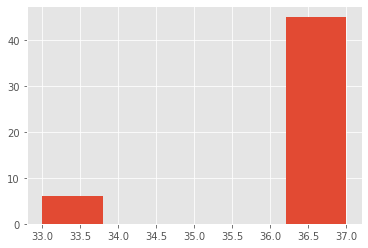

In [ ]:
plt.style.use('ggplot')
plt.hist(phred_scores, bins=5)
plt.show()

**QUESTION 2b**: Please describe the distribution here. Is it normal, is it skewed, etc.? Also, describe the range and if you think this data is low quality, medium quality, or high quality and why?

Q2B Answer here:

# Read Trimming

As mentioned in lecture, the next step after quality control is to trim the reads that are not up to par with our quality levels. Usually, this consists of reads that have a PHRED score of 20 or below. Since our records do not have a PHRED score of less than 20 as seen from the histogram, we will move on from this step for now. Note that we've just looked at one of the reads; in real applications you'll want to filter all reads.

**QUESTION 2c**: Write code that loops over all of the records, finds the average PHRED score in each record, and plots the averages as a histogram. What observations can you make about the average PHRED scores? (Note that since you're looping over 25,000 records, your code might take some time to run)

In [ ]:
# 1) Loop over all records
# 2) Find the average PHRED score in each record
# 3) Plot the averages as histogram

# Write your code here!


Q2C Answer here:

# Data Exploration

Before we move on to alignment, let's convert our fastq file to the FASTA format to analyze and understand the data we're dealing with more.

In [ ]:
from Bio import SeqIO
with open("s_cere_reads.fastq", "r") as input_handle, open("s_cere_reads.fasta", "w") as output_handle:
    sequences = SeqIO.parse(input_handle, "fastq")        
    count = SeqIO.write(sequences, output_handle, "fasta")        
print("Converted %i records" % count)

Converted 25000 records


Now that we have our file in FASTA format under the name `s_cere_reads.fasta`, let's explore some basic genome properties of our first read.

In [ ]:
records_fa = []
records_iter_fa = SeqIO.parse('s_cere_reads.fasta', "fasta")
for record in records_iter_fa:
  # Don't change this line! We're adding all elements of the 
  # iterator into an array we can work with.
  records_fa.append(record)

In [ ]:
rec_1 = records[0]
print(rec_1)

ID: SRR11452750.21.1
Name: SRR11452750.21.1
Description: SRR11452750.21.1 21 length=51
Number of features: 0
Per letter annotation for: phred_quality
Seq('CCGAAGCGCCATCTAGATGAATACGTGAGGCCCATTGGAGGCTCCTTGAGA')


In [ ]:
print(rec_1.seq)

CCGAAGCGCCATCTAGATGAATACGTGAGGCCCATTGGAGGCTCCTTGAGA


In [ ]:
print("Sequence length (bp)", len(rec_1))

Sequence length (bp) 51


As you can see this read has a sequence length of ~50bp which means it is a short read. This means that when aligning, we now know to use an aligner that is best for short-reads. 

***Note***: For now, we have looked at only 1 read, a more accurate representation would be to create a histogram of sequence length for each read so we can get an idea for the average read length rather than from a single record.

## Part 3: Alignment

Alright, now that we have explored our data and have come to the conclusion that we have a short-read sequencing set, we will move on to aligning our data to a reference genome! As mentioned in lecture, aligning reads is like putting puzzle pieces together according to a reference picture. The other option we could take is to do assembly, however that is much more time-consuming and best used if we do not have a reference genome. 

Our reference genome will be the `S. cerevisiae` genome. As for our aligner, we will be using `Bowtie2`, as this is very efficient for short-read alignment.

In order for `Bowtie2` to work, we need to provide it with trimmed reads files and an *index* of the reference genome. We have included this index in the files with this module; you can download indices for other organisms in the sidebar of [Bowtie2's website](http://bowtie-bio.sourceforge.net/bowtie2/index.shtml).


In [ ]:
# The following line will install Bowtie2 on the datahub computer
! sudo apt install bowtie2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  bowtie2-examples
The following NEW packages will be installed:
  bowtie2
0 upgraded, 1 newly installed, 0 to remove and 30 not upgraded.
Need to get 1,174 kB of archives.
After this operation, 5,100 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 bowtie2 amd64 2.3.4.1-1 [1,174 kB]
Fetched 1,174 kB in 1s (888 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package bowtie2.
(Reading data

In [ ]:
# The following line runs the Bowtie2 command
!bowtie2 -x s_cere/s_cere -U s_cere_reads.fastq -S output.sam

25000 reads; of these:
  25000 (100.00%) were unpaired; of these:
    645 (2.58%) aligned 0 times
    16495 (65.98%) aligned exactly 1 time
    7860 (31.44%) aligned >1 times
97.42% overall alignment rate


Let's take apart that command piece-by-piece:
- First, we used the `!` symbol. This is a Jupyter-specific symbol (i.e. it won't work in regular Python) that allows us to run commands *on the command line*. Bowtie2 is an executable program that's usually run from a command line.
- The `-x s_cere/s_cere` portion tells Bowtie2 the location of the *indices* which it uses to align reads. These are in the form of `.bt2` files, which are included in a folder imported with this module.
- The `-U s_cere_reads.fastq` portion tells Bowtie2 the location of the FASTQ file we've been using.
- The `-S output.sam` portion tells Bowtie2 the name we want to give to the output SAM file. This is a type of file often used to represent alignments.

Note also in the output the number of alignments. You should have a high overall alignment rate; unusually low rates may indicate an error, such as low-quality reads or an incorrect index

Let's take a look at this SAM file:

In [ ]:
with open("output.sam", 'r') as f:
  for i in range(25):
    print(f.readline())

@HD	VN:1.0	SO:unsorted

@SQ	SN:I	LN:230218

@SQ	SN:II	LN:813184

@SQ	SN:III	LN:316620

@SQ	SN:IV	LN:1531933

@SQ	SN:IX	LN:439888

@SQ	SN:MT	LN:85779

@SQ	SN:V	LN:576874

@SQ	SN:VI	LN:270161

@SQ	SN:VII	LN:1090940

@SQ	SN:VIII	LN:562643

@SQ	SN:X	LN:745751

@SQ	SN:XI	LN:666816

@SQ	SN:XII	LN:1078177

@SQ	SN:XIII	LN:924431

@SQ	SN:XIV	LN:784333

@SQ	SN:XV	LN:1091291

@SQ	SN:XVI	LN:948066

@PG	ID:bowtie2	PN:bowtie2	VN:2.3.4.1	CL:"/usr/bin/bowtie2-align-s --wrapper basic-0 -x s_cere/s_cere -S output.sam -U s_cere_reads.fastq"

SRR11452750.21.1	16	XII	198920	42	51M	*	0	0	TCTCAAGGAGCCTCCAATGGGCCTCACGTATTCATCTAGATGGCGCTTCGG	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFBFFFFFFFFFFFFFFFBBBBB	AS:i:0	XN:i:0	XM:i:0	XO:i:0	XG:i:0	NM:i:0	MD:Z:51	YT:Z:UU

SRR11452750.172.1	16	XIII	71016	42	51M	*	0	0	ACGATTCTTCTCCCCTTCTTCCAATATTCCCACGGATCGCATCGCATCGCN	FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF<FBFFFFFFFBB<<#	AS:i:-1	XN:i:0	XM:i:1	XO:i:0	XG:i:0	NM:i:1	MD:Z:50C0	YT:Z:UU

SRR11452750.178.1	16	VII	541108	1	51M	*	0	0	CCGACAGTA

We can see that this file starts off with several lines of metadata, followed by a tab-separated table. You may recognize some of the fields of the table from the FASTQ files; to learn more about the SAM format for storing alignments, you can look at the [file specification](http://samtools.github.io/hts-specs/). 

**QUESTION 3**: According to the specification, what do the columns in the table represent? What does the first line in the header mean?

Q3 Answer here:

#Part 4: Gene Counts

Now that we've produced an alignment, the next step is to count each of the reads mapping to each gene. To do this, we will need two things:
1. An alignment, which we have as the SAM file output from Bowtie2.
2. A genome annotation file. The most commonly used file type is a GFF file (you may also see a GTF file; these are identical to version 2 of the GFF specification). These files contain information about the start and end position of each gene, as well as other annotations. 

In our case, we've provided the file `sacCer3.ensGene.gtf` for genome annotations of the *S. cerevisiae* genome, which was downloaded from the [UCSC Genome Browser page](http://hgdownload.soe.ucsc.edu/downloads.html). Let's see what this file looks like:

In [ ]:
with open("sacCer3.ensGene.gtf") as f:
  for i in range(5):
    print(f.readline())

chrIV	ensGene.v101	transcript	1802	2953	.	+	.	gene_id "YDL248W"; transcript_id "YDL248W_mRNA";  gene_name "YDL248W";

chrIV	ensGene.v101	exon	1802	2953	.	+	.	gene_id "YDL248W"; transcript_id "YDL248W_mRNA"; exon_number "1"; exon_id "YDL248W_mRNA.1"; gene_name "YDL248W";

chrIV	ensGene.v101	CDS	1802	2950	.	+	0	gene_id "YDL248W"; transcript_id "YDL248W_mRNA"; exon_number "1"; exon_id "YDL248W_mRNA.1"; gene_name "YDL248W";

chrIV	ensGene.v101	start_codon	1802	1804	.	+	0	gene_id "YDL248W"; transcript_id "YDL248W_mRNA"; exon_number "1"; exon_id "YDL248W_mRNA.1"; gene_name "YDL248W";

chrIV	ensGene.v101	stop_codon	2951	2953	.	+	0	gene_id "YDL248W"; transcript_id "YDL248W_mRNA"; exon_number "1"; exon_id "YDL248W_mRNA.1"; gene_name "YDL248W";



We can see that we have another tab-delimited table of values.

**QUESTION 4a**: Look up the GTF file description. What do each of the columns mean? What does the first line of the annotation mean?

Q4a Answer here:

In order to find gene counts, we'll be using the package `HTSeq`. We can install the package with the line below:

In [ ]:
!pip install pysam htseq

     |████████████████████████████████| 9.9MB 7.5MB/s 
     |████████████████████████████████| 1.3MB 41.4MB/s 


`HTSeq` is once again run from the command line; we can run it with our files as follows:

In [ ]:
!htseq-count output.sam sacCer3.ensGene.gtf > s_cere_counts.tsv

34755 GFF lines processed.
25000 alignments  processed.


In this command, the program we are running is `htseq-count`. The two arguments are our alignment (`output.sam`) and the annotation (`sacCer3.ensGene.gtf`). We then use a *redirect character* (`>`) to send the output of the command to a file, `s_cere_counts.tsv`.

We can view the contents of this TSV file as follows:

In [ ]:
with open("s_cere_counts.tsv") as f:
  for i in range(5):
    print(f.readline())

ETS1-1	0

ETS1-2	0

ETS2-1	0

ETS2-2	0

HRA1	0



This file has two columns: the first is the gene name, and the second is the count for that gene. 

**QUESTION 4b**: Use pandas to read in the count data (*hint:* remember the pd.read_csv() function) and make a barplot for the genes that have nonzero counts.

In [ ]:
# Write your code here